# Plot Maps


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import iris
import iris.plot as iplt
import iris.quickplot as qplt

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER



### Load location of EEL stations

In [10]:
pathdir = '../data/raw'

file3 = pathdir+'/'+'EELCTDandLADCP_refpos_gvel.csv'
dfloc = pd.read_csv(file3,sep=',', index_col=None, 
                     header=0)
print(dfloc)

   Staname      Refdist  RefLonGV  RefLatGV  RefDepthGV
0      1G+  1302.899438   -6.2080   56.6750       110.0
1      2G+  1295.320496   -6.3250   56.6955        50.0
2      3G+  1289.519062   -6.4085   56.7205        92.5
3      4G+  1282.060930   -6.5250   56.7330        97.5
4      5G+  1272.917843   -6.6750   56.7330        60.0
..     ...          ...       ...       ...         ...
63  IB18S+   103.065137  -19.7510   62.5000      1730.0
64  IB19S+    69.821265  -19.6095   62.7920      1535.0
65  IB20S+    40.495971  -19.7335   63.0250      1215.0
66  IB21S+    19.408577  -19.9915   63.1745       850.0
67  IB22S+     6.721022  -20.1410   63.2665       395.0

[68 rows x 5 columns]


<br><br>
## Plot Station Location

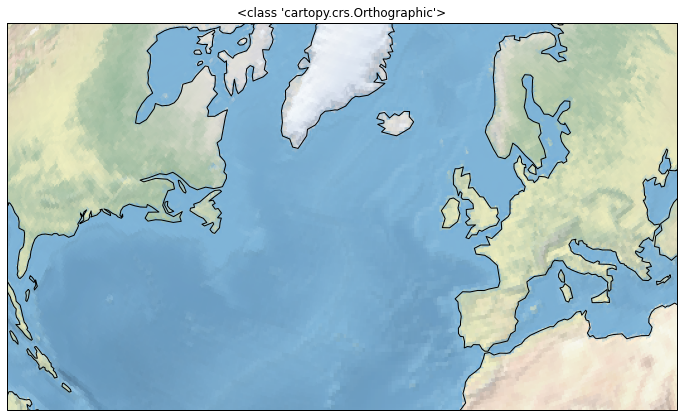

In [11]:
#proj = ccrs.Robinson(-20)
proj = ccrs.Orthographic(-20, 50)

plt.figure(figsize=(12, 12))
ax = plt.axes(projection=proj)
ax.stock_img()
ax.coastlines()
ax.set_title(f'{type(proj)}')
ax.set_extent([-80, 20, 20, 70])

<br><br>
#### Plot a topography map using the etopo1 data from the NOAA opendap server. With iris we can slice the data before downloading it. Finally we will "print" our cube to check the metadata.

In [7]:
# Definition variables for maps
central_lon, central_lat = -10, 45
extent_extract = [-30, 10, 50, 70]
extent_map = [-26, 0, 51, 66]

In [8]:
def get_cube(url):
    coord_values = {'latitude':lambda cell: extent_extract[2] <= cell <= extent_extract[3],
                    'longitude': lambda cell: extent_extract[0] <= cell <= extent_extract[1]}
    constraint = iris.Constraint(coord_values=coord_values)
    bathy = iris.load_cube(url, constraint)
    return bathy

try:
    bathy = get_cube('/Users/locupe/Dropbox/Work/function_MATLAB/bathymetrie/ETOPO1_Ice_c_gmt4.grd')
except:
    bathy = get_cube('http://www.ngdc.noaa.gov/thredds/dodsC/relief/ETOPO1/thredds/ETOPO1_Bed_g_gmt4.nc')


print(bathy)

z / (1)                             (latitude: 1200; longitude: 2400)
     Dimension coordinates:
          latitude                           x                -
          longitude                          -                x
     Attributes:
          Conventions: COARDS/CF-1.0
          GMT_version: 4.4.0
          actual_range: [-10803.   8333.]
          node_offset: 1
          title: ETOPO1_Ice_c_gmt4.grd


<br><br>
#### Now we plot the regional bathymetry map

In [12]:
import palettable

from palettable import colorbrewer
from palettable.cmocean.sequential import Ice_12 as ocean
# help(colorbrewer)
# colorbrewer.print_maps

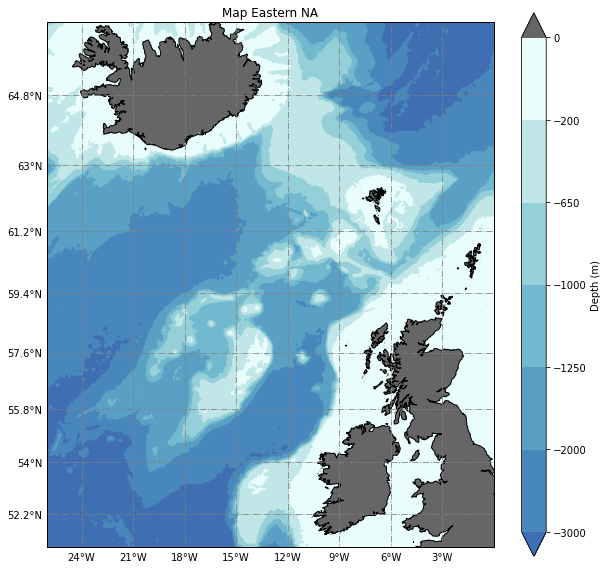

In [13]:
land = colorbrewer.get_map('Accent', 'qualitative', 8)
#ocean = colorbrewer.get_map('Blues', 'sequential', 6, reverse=True)
colors = np.array(ocean.mpl_colors[-6:])

levels = [-3000, -2000, -1250, -1000, -650, -200, 0]

titlefig = 'Map Eastern NA'

fig, ax = plt.subplots(figsize=(10, 10),
                       subplot_kw=dict(projection=ccrs.Mercator(central_lon, central_lat)))
countplt = iris.plot.contourf(bathy, levels, colors=colors, extend='both')
countplt.cmap.set_under(ocean.mpl_colors[-7])
countplt.cmap.set_over(land.mpl_colors[-1])

cbar = plt.colorbar(countplt, ax=ax, orientation="vertical", pad=.05)  
cbar.ax.set_ylabel('Depth (m)')

ax.set_extent(extent_map)
ax.set_title(f'{titlefig}')
ax.coastlines('10m', color='k')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0.8, linestyle='-.')

gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


## TODO1: Add location of EEL station 

## TODO2: Produce other version of the figure with mean current ellipses at different depths (eg 100m, 800m, 2500m), perhaps with some representation of data coverage (eg dot size to indicate number of occupations of each station)